## Neural style transfer to merge the content of one image with the style of another, using a pre-trained model VGG-19.

In [85]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='/content/drive/MyDrive/datasets/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

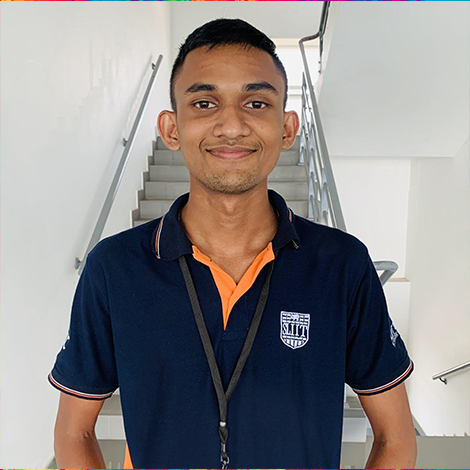

In [88]:
content_image = Image.open("/content/drive/MyDrive/datasets/dp4100.png")
content_image

In [89]:
def compute_content_cost(content_output, generated_output):

    a_C = content_output[-1]
    a_G = generated_output[-1]

    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_C, shape=[m, -1 , n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_G, shape=[m, -1 , n_C])

    # compute the cost with tensorflow (≈1 line)
    J_content =  tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)

    return J_content

In [90]:
tf.random.set_seed(1)
a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_content = compute_content_cost([a_C], [a_G])
J_content_0 = compute_content_cost([a_C], [a_C])
assert type(J_content) == EagerTensor, "Use the tensorflow function"
assert np.isclose(J_content_0, 0.0), "Wrong value. compute_content_cost(A, A) must be 0"
assert np.isclose(J_content, 7.0568767), f"Wrong value. Expected {7.0568767},  current{J_content}"

print("J_content = " + str(J_content))

print("\033[92mAll tests passed")

J_content = tf.Tensor(7.056877, shape=(), dtype=float32)
All tests passed


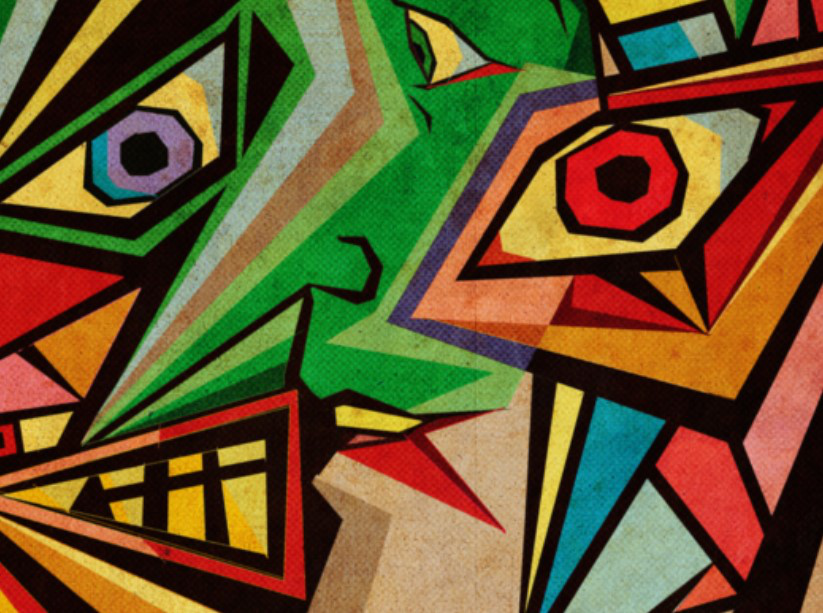

In [91]:
example = Image.open("/content/drive/MyDrive/datasets/05.png")
example

In [92]:
def gram_matrix(A):

    GA = tf.matmul(A, tf.transpose(A))

    return GA

In [93]:
tf.random.set_seed(1)
A = tf.random.normal([3, 2 * 1], mean=1, stddev=4)
GA = gram_matrix(A)

assert type(GA) == EagerTensor, "Use the tensorflow function"
assert GA.shape == (3, 3), "Wrong shape. Check the order of the matmul parameters"
assert np.allclose(GA[0,:], [63.1888, -26.721275, -7.7320204]), "Wrong values."

print("GA = \n" + str(GA))

print("\033[92mAll tests passed")

GA = 
tf.Tensor(
[[ 63.188793  -26.721273   -7.7320204]
 [-26.721273   12.76758    -2.5158243]
 [ -7.7320204  -2.5158243  23.752384 ]], shape=(3, 3), dtype=float32)
All tests passed


In [94]:
def compute_layer_style_cost(a_S, a_G):

    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))

    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))

    return J_style_layer

In [95]:
tf.random.set_seed(1)
a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_style_layer_GG = compute_layer_style_cost(a_G, a_G)
J_style_layer_SG = compute_layer_style_cost(a_S, a_G)


assert type(J_style_layer_GG) == EagerTensor, "Use the tensorflow functions"
assert np.isclose(J_style_layer_GG, 0.0), "Wrong value. compute_layer_style_cost(A, A) must be 0"
assert J_style_layer_SG > 0, "Wrong value. compute_layer_style_cost(A, B) must be greater than 0 if A != B"
assert np.isclose(J_style_layer_SG, 14.017805), "Wrong value."

print("J_style_layer = " + str(J_style_layer_SG))

print("\033[92mAll tests passed")

J_style_layer = tf.Tensor(14.017806, shape=(), dtype=float32)
All tests passed


In [96]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0     

In [97]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

In [98]:
STYLE_LAYERS = [
    ('block1_conv1', 1.0),
    ('block2_conv1', 0.8),
    ('block3_conv1', 0.7),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.1)]

In [99]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):

    # initialize the overall style cost
    J_style = 0
    a_S = style_image_output[1:]

    # Set a_G to be the output of the choosen hidden layers.
    a_G = generated_image_output[1:]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        J_style += weight[1] * J_style_layer

    return J_style

In [100]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):

    J = alpha * J_content + beta * J_style

    return J

In [101]:
J_content = 0.2
J_style = 0.8
J = total_cost(J_content, J_style)

assert type(J) == EagerTensor, "J must be an EagerTensor"
assert J == 34, "J must be equal to 34"
assert np.isclose(total_cost(0.3, 0.5, 3, 8), 4.9), "total_cost(0.3, 0.5, 3, 8) must be close to 4.9"

np.random.seed(1)
print("J = " + str(total_cost(np.random.uniform(0, 1), np.random.uniform(0, 1))))

print("\033[92mAll tests passed")


J = tf.Tensor(32.9832, shape=(), dtype=float32)
All tests passed


(1, 400, 400, 3)


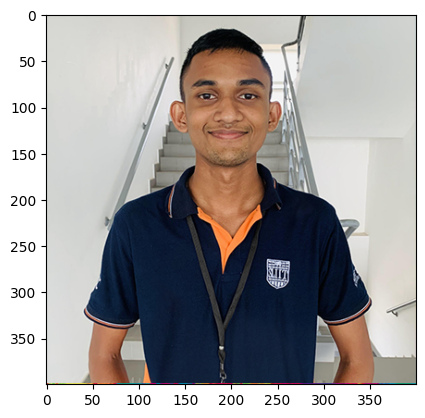

In [102]:
content_image = np.array(Image.open("/content/drive/MyDrive/datasets/dp4100.png").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


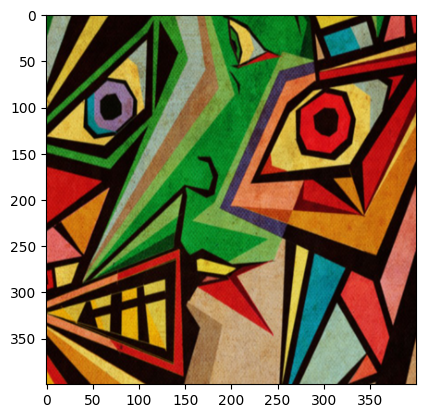

In [103]:
style_image =  np.array(Image.open("/content/drive/MyDrive/datasets/05.png").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


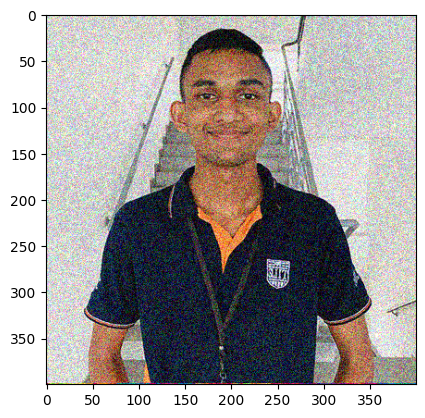

In [104]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [105]:
def get_layer_outputs(vgg, layer_names):
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [106]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [107]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

In [108]:
# Assign the content image to be the input of the VGG model.
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [109]:
# Assign the input of the model to be the "style" image
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [110]:
def clip_0_1(image):

    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):

    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [111]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:

        a_G = vgg_model_outputs(generated_image)

        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G)
        J_content = compute_content_cost(a_C, a_G)
        J = total_cost(J_content, J_style)

    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J

In [112]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

J1 = train_step(generated_image)
print(J1)
assert type(J1) == EagerTensor, f"Wrong type {type(J1)} != {EagerTensor}"

J2 = train_step(generated_image)
print(J2)
#assert np.isclose(J2, 6081.23541, rtol=0.05), f"Unexpected cost for epoch 1: {J2} != {6081.2354}"

print("\033[92mAll tests passed")

tf.Tensor(102250.625, shape=(), dtype=float32)
tf.Tensor(83686.48, shape=(), dtype=float32)
All tests passed


In [113]:
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"\033[92mEpoch {i}\033[0m")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"/content/drive/MyDrive/datasets/image_{i}.jpg")
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

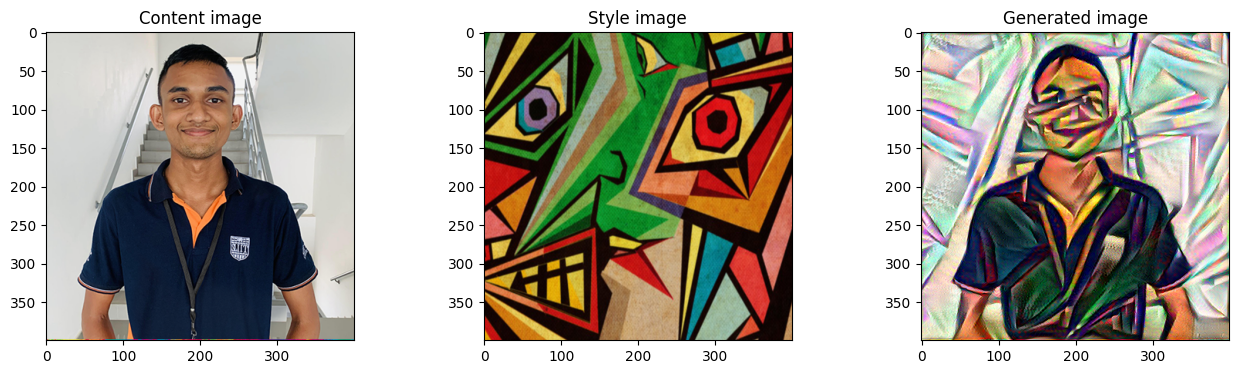

In [116]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

In [115]:
print(f"\033[92mEpoch {i}\033[0m")

Epoch 2500
